# Bitcoin - Interest rate connect

Taking Idea from the previous Quant Strategies for Crypto markets, In this notebook we are going to take a look into Bitcoin and Interes rate connect / disconnect

In [218]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Data sources

Macro data - https://www.fxstreet.com/economic-calendar

Bitcoin data - https://www.kaggle.com/datasets/prasoonkottarathil/btcinusd or https://in.investing.com/crypto/bitcoin/historical-data

In [219]:
def import_data(file_path):
    data = pd.read_csv(file_path)
    return data

In [220]:
bitcoin = import_data('data/Bitcoin.csv')
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
bitcoin['Price'] = bitcoin['Price'].str.replace(',', '')
bitcoin = bitcoin[(bitcoin['Date'].dt.year > 2014)].reset_index(drop=True)

bitcoin['Close'] = bitcoin['Price'].astype(float)
bitcoin['Date'][0]

Timestamp('2015-01-01 00:00:00')

In [222]:
def rates(file_path):
    rate = import_data(file_path)
    rate['DATE'] = pd.to_datetime(rate['DATE'], format='%m/%d/%Y')
    rate['Date'] = rate['DATE']
#     rate = rate[(rate['DATE'].dt.year > 2010) | ((rate['DATE'].dt.year == 2010) & (rate['DATE'].dt.month >=7))]
    rate = rate[(rate['DATE'].dt.year > 2014)]
    rate = rate.iloc[::-1].reset_index(drop=True)
    return rate
fed = rates('data/Rates/Interest Rates - US.csv')

In [223]:

fed.head(5)
# bitcoin.head(5)

,DATE,ACTUAL,DEV,CONS,Date
0,2015-01-28,0.25,0.0,0.25,2015-01-28
1,2015-03-18,0.25,0.0,0.25,2015-03-18
2,2015-04-29,0.25,0.0,0.25,2015-04-29
3,2015-06-17,0.25,0.0,0.25,2015-06-17
4,2015-07-29,0.25,0.0,0.25,2015-07-29


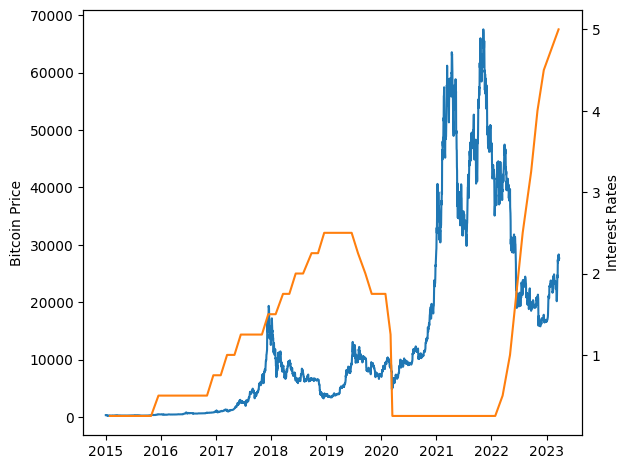

In [224]:
def plot(bitcoin, rate):
    fig, ax1 = plt.subplots(sharex=True)
    ax2 = ax1.twinx()

    ax1.plot(bitcoin['Date'], bitcoin['Close'], label='Bitcoin Prices', color='C0')
    ax2.plot(rate['Date'], rate['ACTUAL'], label='Interest Rates', color='C1')

    ax1.set_ylabel('Bitcoin Price')
    ax2.set_ylabel('Interest Rates')

    fig.tight_layout()
    plt.show()
plot(bitcoin, fed)

In [226]:
def clean_merge_df(merged_df):
#     merged_df = merged_df.drop(columns=['DEV', 'CONS', 'Unix', 'Symbol', 'Volume BTC', 'tradecount', 'Volume USDT'])
    merged_df['new_index'] = range(len(merged_df))
    merged_df.set_index('new_index', inplace=True)
    return merged_df
def merge(bitcoin, rate):
    rate_df = rate.copy()
    bitcoin_df = bitcoin.copy()

    # Set the date columns as the index
    rate_df['Date'] = pd.to_datetime(rate_df['Date'])
    bitcoin_df['Date'] = pd.to_datetime(bitcoin_df['Date'])
    rate_df.set_index('Date', inplace=True)
    bitcoin_df.set_index('Date', inplace=True)

    # Merge the dataframes based on the date column
    merged_df = pd.merge(rate_df, bitcoin_df, how='outer', left_index=True, right_index=True)

    # Forward fill
    merged_df['ACTUAL'].fillna(method='ffill', inplace=True)
    merged_df['Rate Changed'] = merged_df['ACTUAL'].diff() != 0
    merged_df = clean_merge_df(merged_df)
    return merged_df

# merged_df = merge(bitcoin, fed)
# merged_df.tail(10)

In [227]:
def plot_bitcoin_performance(performance):
    fig, ax1 = plt.subplots()
    ax1.scatter(performance['Days Since Fed Rate Change'], performance['Bitcoin Return'], c=performance['Pos / Neg'].replace({True: 'g', False: 'r'}))

    ax1.set_ylabel('Days Since Fed Rate Change')
    ax1.set_xlabel('Bitcoin Return')

    fig.tight_layout()
    plt.show()


In [228]:
def plot_per_day_df(perDay):
    fig, ax1 = plt.subplots(figsize=(9, 5))


    for i, row in perDay.iterrows():
        new_row = row.drop(columns=['Pos'])
        ax1.plot(row, label=i, color='green' if row['Pos'] == True else 'red')

    ax1.set_xlabel('Days Since Fed Rate Change')
    ax1.set_ylabel('Bitcoin Return')
    plt.title('Bitcoin Performance After Fed Rate Change')
    plt.show()
def plot_change(changes):
    fig, ax1 = plt.subplots(figsize=(9, 5))


    ax1.plot(changes)

    ax1.set_xlabel('Index')
    ax1.set_ylabel('Changes')
    plt.show()

In [229]:
def simple_linear_reg(value_change, debug):
    relation_df = pd.DataFrame(columns=['Rate Change', 'Price Change'])
    for ele in value_change:
        relation_df = relation_df.append({'Rate Change': ele['rate_diff'], 'Price Change': ele['price_diff']}, ignore_index=True)
    # Calculate the correlation coefficient
    corr_coef = relation_df['Rate Change'].corr(relation_df['Price Change'])
    
    # Simple linear regression model
    if debug:
        print("Correlation coefficient:", corr_coef)
        print(relation_df)
    model = sm.formula.ols(formula='Q("Price Change") ~ Q("Rate Change")', data=relation_df).fit()

    if debug:
        print(model.summary())
    return model.rsquared

    

In [230]:
def get_price_changes(bitcoin, rate, no_of_days, debug):
    if debug:
        plot(bitcoin, rate)
    merged_df = merge(bitcoin, rate)

#   Initialize
    prev = None
#   Used store overall change in price
    cols = [str(i) for i in range(no_of_days+1)]
    cols.append('Pos')
    perDay = pd.DataFrame(columns=cols)
    new_row = pd.Series(dtype='object')


#   Calculating change in price for each day
    bitcoin_performance = pd.DataFrame(columns=['Days Since Fed Rate Change', 'Bitcoin Return', 'Pos / Neg'])
    
    overall_change = []
    value_change = []
    pos_announcement = []
    neg_announcement = []
    
#   Loop thorugh db
    for index, row in merged_df.iterrows():
        if pd.isnull(row['Open']) or row['Rate Changed'] is False or pd.isnull(row['ACTUAL']):
            prev = row
            continue

#       Row where Fed Changed rate and bitcoin value is present in db

#       Get the values of the next days
        next_values = merged_df.loc[index:index+no_of_days, 'Close']
        first_value = next_values.iloc[0]

        percentage_changes = ((next_values - first_value) / first_value) * 100

#       If rate increased -> Negative announcement else Positive
        pos = False if row['ACTUAL'] > prev['ACTUAL'] else True

        perDay = perDay.append(new_row, ignore_index = True)
        for i in range(len(percentage_changes)):
            if len(perDay[str(i)]) == 0:
                perDay[str(i)] = [0]
            perDay[str(i)][len(perDay[str(i)]) - 1] = percentage_changes.iloc[i]
        perDay['Pos'][len(perDay['Pos']) - 1] = pos

        change = ((next_values.iloc[-1] - next_values.iloc[0]) / next_values.iloc[0]) * 100
        overall_change.append(change)

        value_change.append({'rate_diff': row['ACTUAL'] - prev['ACTUAL'], 'price_diff': change})
        
        if not pos:
            neg_announcement.append(change)
        else:
            pos_announcement.append(change)

        bitcoin_returns = next_values.pct_change().iloc[:5]
        count =0
        for j in range(len(bitcoin_returns)):
            bitcoin_performance = bitcoin_performance.append({'Days Since Fed Rate Change': count,
                                                                  'Bitcoin Return': bitcoin_returns.iloc[j], 'Pos / Neg': pos}, ignore_index=True)
            count = count + 1
        prev = row
    if debug:
        plot_change(overall_change)
        if len(pos_announcement) != 0:
            print("Avg change after positive announcement or decrease in rates after " + str(no_of_days) + " days: " + str(sum(pos_announcement) / len(pos_announcement)))
        if len(neg_announcement) != 0:
            print("Avg change after negative announcement or increase in rates after " + str(no_of_days) + " days: " + str(sum(neg_announcement) / len(neg_announcement)))
        plot_bitcoin_performance(bitcoin_performance)
        plot_per_day_df(perDay)
    
    r_sq = simple_linear_reg(value_change, debug)
    return bitcoin_performance, perDay, r_sq


In [231]:
# bitcoin_performance, perDay, r_sq = get_price_changes(bitcoin, fed, 7, False)
# last_row_index = perDay.index[-1]
# perDay = perDay.drop(last_row_index)



In [232]:
country_list = ['US', 'Europe', 'China', 'BoE', 'Canada', 'Swiss', 'New Zealand', 'Aus', 'India']
r_max = -1
r_country = ""
r_day = -1
for day in range(1, 10):
    r_l_max = -1
    r_l_country = ""
    for country in country_list:
        rate = rates('data/Rates/Interest Rates - ' + country + '.csv')
        bitcoin_performance, perDay, r_sq = get_price_changes(bitcoin, rate, day, False)
        if r_sq > r_l_max:
            r_l_max = r_sq
            r_l_country = country
    print("Max r_sq is: " + str(r_l_max) + ", for: " + r_l_country + ", for day: " + str(day))
    if r_l_max > r_max:
        r_max = r_l_max
        r_country = r_l_country
        r_day = day
print("Overall Max r_sq is: " + str(r_max) + ", for: " + r_country + ", for day: " + str(r_day))   

Max r_sq is: 0.3853063409510722, for: BoE, for day: 1
Max r_sq is: 0.29712532756740806, for: BoE, for day: 2
Max r_sq is: 0.32093825955847644, for: BoE, for day: 3
Max r_sq is: 0.36858052230017113, for: China, for day: 4
Max r_sq is: 0.3945512146722029, for: China, for day: 5
Max r_sq is: 0.9145310742572228, for: Swiss, for day: 6
Max r_sq is: 0.38936725654884685, for: China, for day: 7
Max r_sq is: 0.5301507213054321, for: China, for day: 8
Max r_sq is: 0.4265061459599201, for: China, for day: 9
Overall Max r_sq is: 0.9145310742572228, for: Swiss, for day: 6


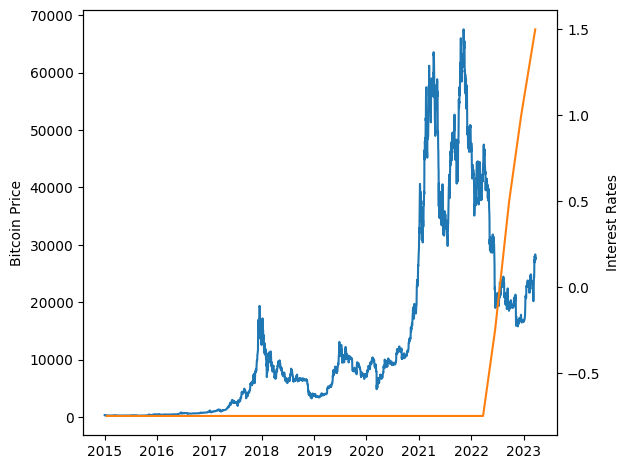

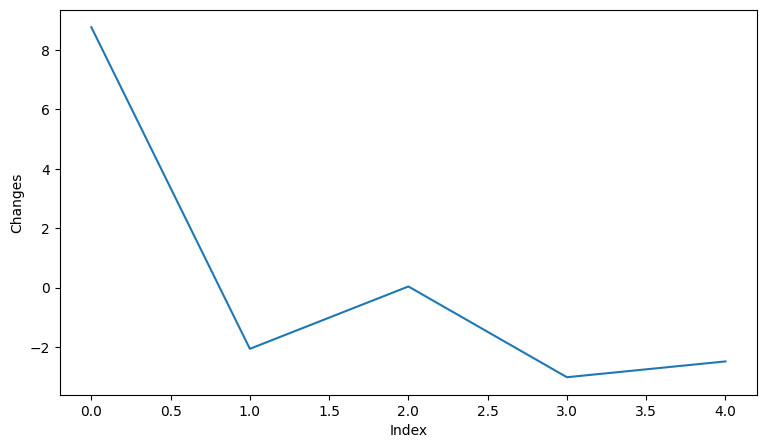

Avg change after positive announcement or decrease in rates after 6 days: 8.770257387988549
Avg change after negative announcement or increase in rates after 6 days: -1.8844193697310323


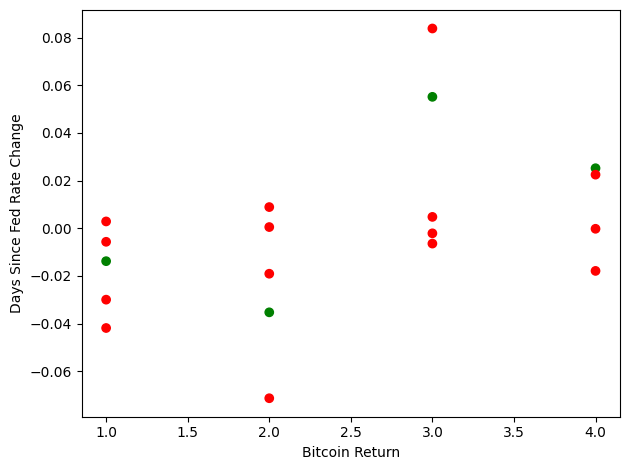

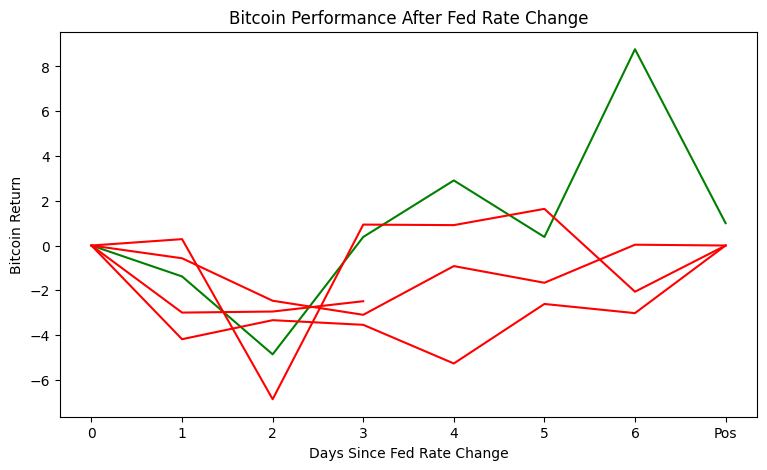

Correlation coefficient: 0.9563111806609932
   Rate Change  Price Change
0          NaN      8.770257
1         0.50     -2.064101
2         0.75      0.036075
3         0.50     -3.020840
4         0.50     -2.488812
                            OLS Regression Results                            
Dep. Variable:      Q("Price Change")   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     21.40
Date:                Sun, 26 Mar 2023   Prob (F-statistic):             0.0437
Time:                        09:52:47   Log-Likelihood:                -1.3483
No. Observations:                   4   AIC:                             6.697
Df Residuals:                       2   BIC:                             5.469
Df Model:                           1                                         
Covariance Type:            nonrobust                                  

In [217]:
rate = rates('data/Rates/Interest Rates - ' + "Swiss" + '.csv')
bitcoin_performance, perDay, r_sq = get_price_changes(bitcoin, rate, 6, True)